In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 6.3 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
import shap


In [30]:
# Load the data
df = pd.read_excel('/content/sample_data/Data_Combined.xlsx')

# 1. Filter data for Pfizer and J&J vaccinations only
df = df[df['Vaccine_Type'].isin(['Pfizer', 'J&J'])]


In [31]:
df.columns

Index(['Unnamed: 0', 'Patient_Number', 'Glucose_Level', 'Cholestrol', 'Temp',
       'Weight', 'BMI', 'Height', 'Waist_circumference', 'HB', 'Gender_x',
       'Age', 'HLE', 'Smoking', 'Physical_activity', 'PA/week', 'PA level',
       'HPT', 'Low/high_Blood_sugar', 'Fam_hx_CVD', 'High_Chol',
       'Kidney_problems', 'Liver_problems', 'Gender_y', 'Participant_Number',
       'Age_of_Participant_b', 'Vaccine_Type', 'Vaccination_Status',
       'Number_of_Doses', 'Boosting_Status', 'Side_Effects',
       'Symptoms_and_Treatment', 'Hospitalization', 'Co-Morbidities',
       'BP_Average', 'Weight_Category', 'Occupation', 'Marital_status',
       'Hazardous exposure', 'Alcohol', 'Symp_Cold', 'Symp_Cough',
       'Symp_Sore_throat', 'Symp_Headache', 'breathlessness', 'taste_Smell',
       'Close_to_Someonewith_Covid', 'COVID-19_comorbidities', 'Symp_Cold_i',
       'Symp_Cough_i', 'Symp_Sore_throat_i', 'Symp_Headache_i',
       'breathlessness_i', 'taste_Smell_i', 'Close_to_Someonewith_Covi

In [32]:
# 2. Feature engineering and removal of redundant features
# Assuming 'Vaccinated_SARS-CoV-2' is the column for vaccination status
df['VaccinationStatus'] = df['Vaccination_Status'].map({'complete': 1, 'incomplete': 0})
df['BoostingStatus'] = df['Boosting_Status'].map({'boosted': 1, 'Not Boosted': 0})
df['Breakthrough_Infection'] = df['break_through'].map({'Y': 1, 'N': 0})

# Remove redundant features
columns_to_drop = ['Vaccination_Status', 'break_through', 'Patient_Number', 'Participant_Number']
df = df.drop(columns=columns_to_drop)



In [35]:
# 3. Data cleaning and preprocessing
# Handle missing data
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encoding categorical data
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    # Convert the column to string type to ensure uniformity
    df[column] = df[column].astype(str)  # Convert the column to string type

    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Scaling numerical data
scaler = StandardScaler()
df[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))

# Handle missing data if any
df.fillna(df.mean(), inplace=True)

In [41]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

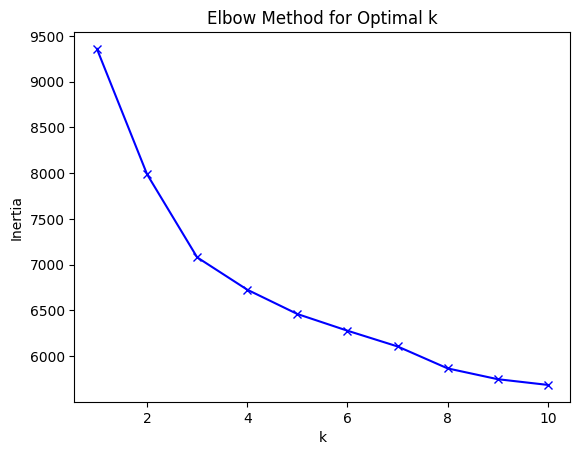

In [42]:
# 4. Elbow method to find optimal number of clusters
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


In [38]:
optimal_k = 10


In [43]:
# 5. Train K-means model and evaluate
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(df)

silhouette_avg = silhouette_score(df, cluster_labels)
calinski_harabasz = calinski_harabasz_score(df, cluster_labels)
wcss = kmeans.inertia_
ari = adjusted_rand_score(df['Vaccine_Type'], cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Within-Cluster Sum of Squares: {wcss}")
print(f"Adjusted Rand Index: {ari}")


Silhouette Score: 0.05734545781514118
Calinski-Harabasz Score: 10.482550053461686
Within-Cluster Sum of Squares: 5684.660179401128
Adjusted Rand Index: 0.04192462990253218


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


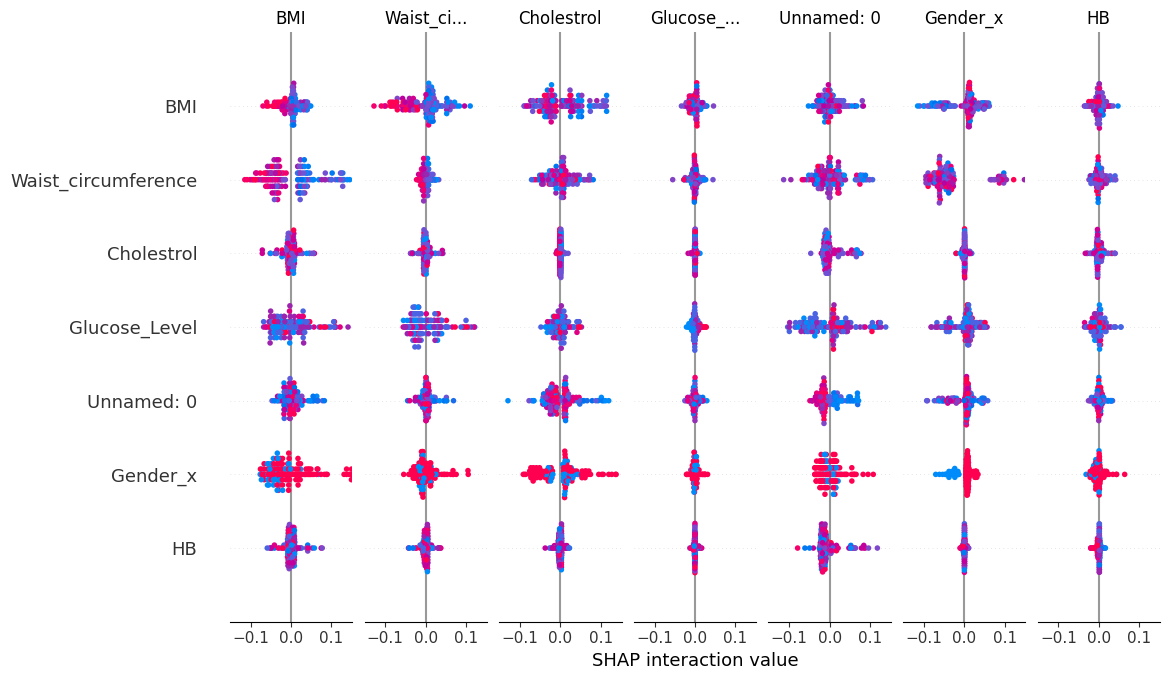

In [45]:
# 6. Random Forest Classifier and SHAP
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(df, cluster_labels)

explainer = shap.TreeExplainer(rf_classifier)
shap_values = explainer.shap_values(df)

shap.summary_plot(shap_values, df, plot_type="bar")


In [46]:
# Get feature importance
feature_importance = pd.DataFrame({'feature': df.columns, 'importance': rf_classifier.feature_importances_})
top_features = feature_importance.sort_values('importance', ascending=False).head(10)


In [47]:
df.columns

Index(['Unnamed: 0', 'Glucose_Level', 'Cholestrol', 'Temp', 'Weight', 'BMI',
       'Height', 'Waist_circumference', 'HB', 'Gender_x', 'Age', 'HLE',
       'Smoking', 'Physical_activity', 'PA/week', 'PA level', 'HPT',
       'Low/high_Blood_sugar', 'Fam_hx_CVD', 'High_Chol', 'Kidney_problems',
       'Liver_problems', 'Gender_y', 'Age_of_Participant_b', 'Vaccine_Type',
       'Number_of_Doses', 'Boosting_Status', 'Side_Effects',
       'Symptoms_and_Treatment', 'Hospitalization', 'Co-Morbidities',
       'BP_Average', 'Weight_Category', 'Occupation', 'Marital_status',
       'Hazardous exposure', 'Alcohol', 'Symp_Cold', 'Symp_Cough',
       'Symp_Sore_throat', 'Symp_Headache', 'breathlessness', 'taste_Smell',
       'Close_to_Someonewith_Covid', 'COVID-19_comorbidities', 'Symp_Cold_i',
       'Symp_Cough_i', 'Symp_Sore_throat_i', 'Symp_Headache_i',
       'breathlessness_i', 'taste_Smell_i', 'Close_to_Someonewith_Covid_i',
       'sample_id', 'APOE2', 'APOE4', 'raw_APOE2', 'raw_APOE4',

In [48]:
# 7. Distribution of vaccines and breakthrough infections in clusters
df['Cluster'] = cluster_labels
vaccine_distribution = df.groupby(['Cluster', 'Vaccine_Type']).size().unstack(fill_value=0)
bt_infection_distribution = df.groupby(['Cluster', 'Breakthrough_Infection']).size().unstack(fill_value=0)
bt_infection_percentage = df.groupby(['Cluster', 'Vaccine_Type'])['Breakthrough_Infection'].mean().unstack(fill_value=0) * 100


In [49]:
print("Vaccine Distribution:")
print(vaccine_distribution)
print("\nBreakthrough Infection Distribution:")
print(bt_infection_distribution)
print("\nBreakthrough Infection Percentage:")
print(bt_infection_percentage)


Vaccine Distribution:
Vaccine_Type  -1.674777   0.597094
Cluster                           
0                     6         12
1                     2         19
2                     7         12
3                     1          0
4                     2          3
5                     3         24
6                     7          2
7                     0         23
8                     4         10
9                     9         10

Breakthrough Infection Distribution:
Breakthrough_Infection  -0.508001   1.968502
Cluster                                     
0                              15          3
1                              12          9
2                              19          0
3                               0          1
4                               5          0
5                              23          4
6                               7          2
7                              14          9
8                              14          0
9                        

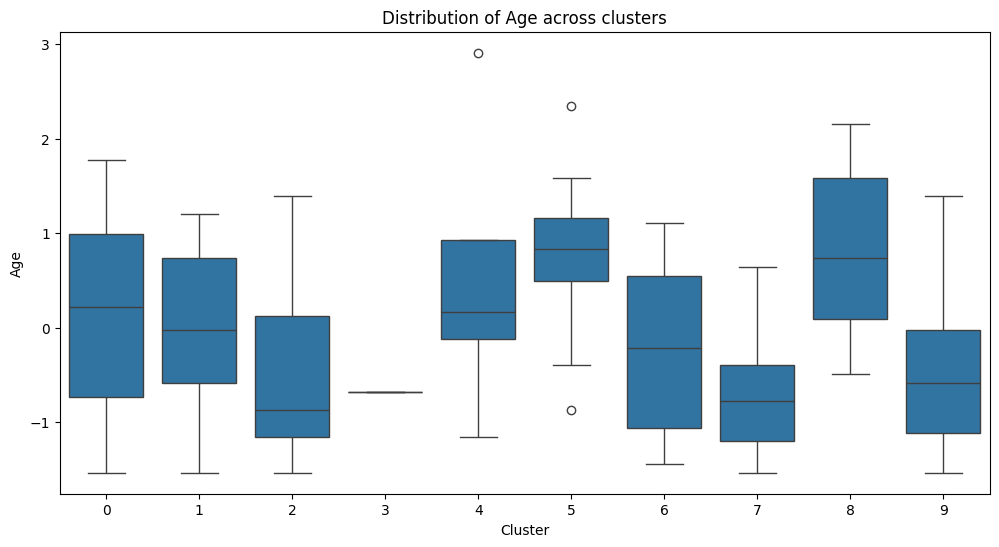

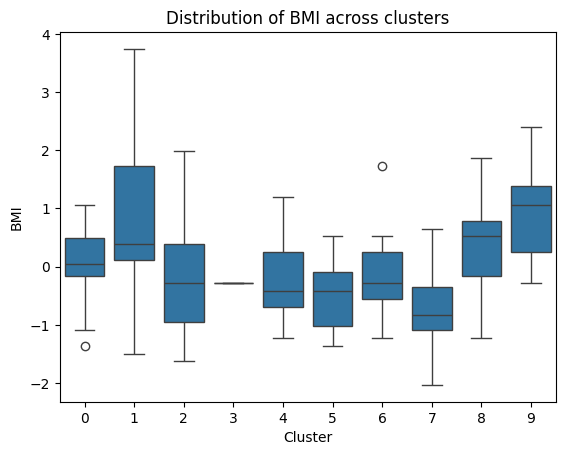

In [50]:
# 8. Visualizations
# Mean values of important numerical features
plt.figure(figsize=(12, 6))
for feature in top_features['feature'][:5]:  # Top 5 numerical features
   if feature in numerical_columns:
        sns.boxplot(x='Cluster', y=feature, data=df)
        plt.title(f'Distribution of {feature} across clusters')
        plt.show()



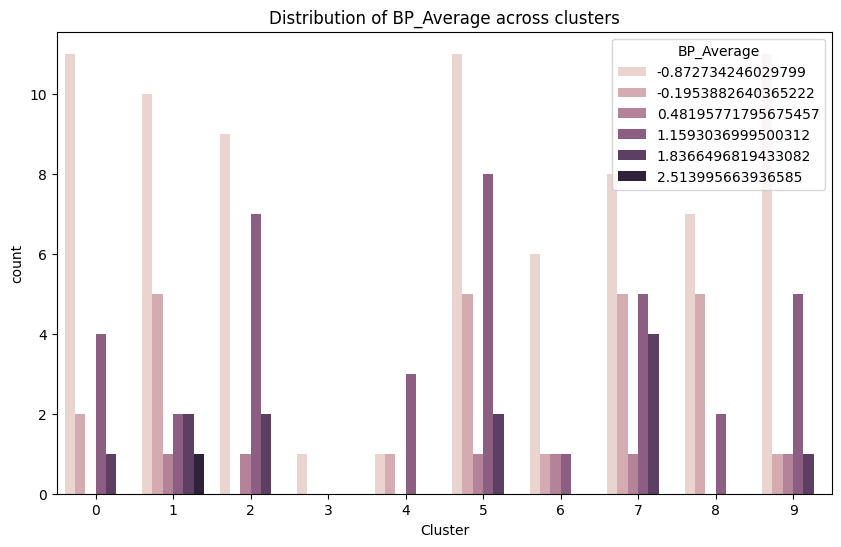

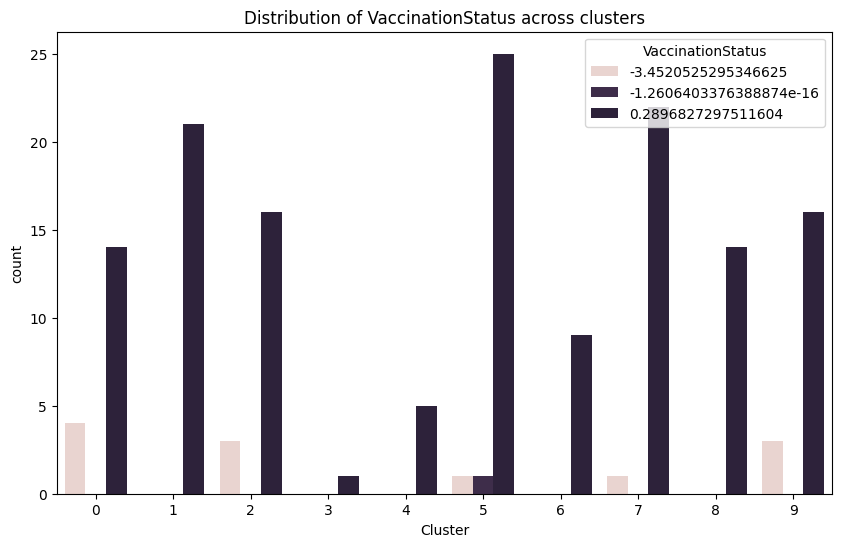

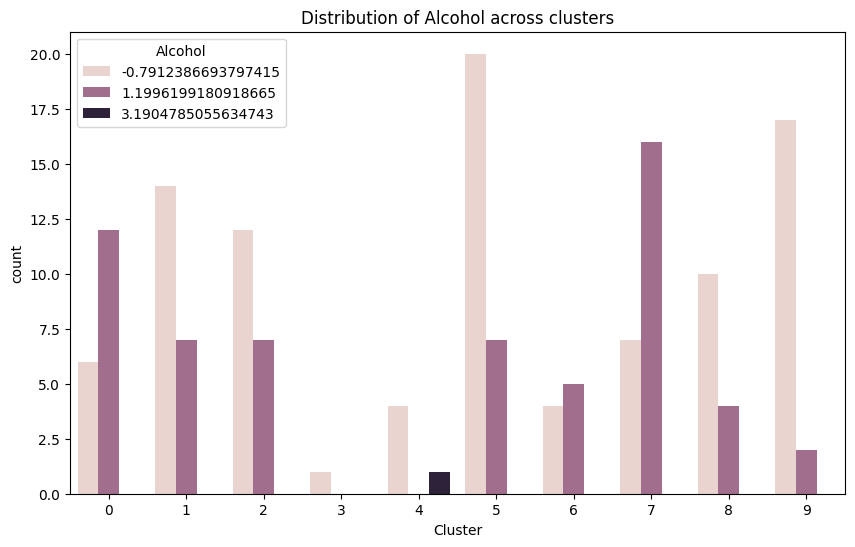

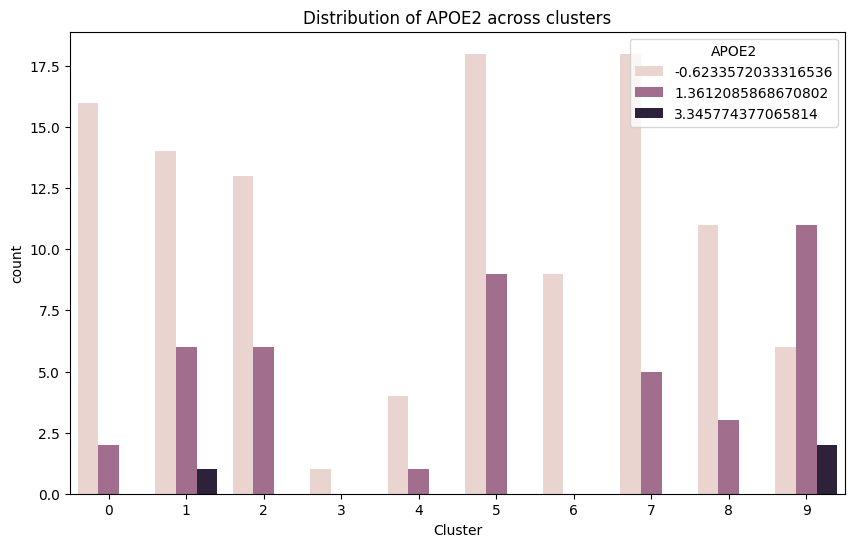

In [52]:
# Categorical features
categorical_features = ['BP_Average', 'VaccinationStatus', 'Alcohol', 'APOE2']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster', hue=feature, data=df)
    plt.title(f'Distribution of {feature} across clusters')
    plt.show()


In [53]:
# 9. Distribution of categorical values in clusters
for feature in ['BP_Average', 'Gender_x', 'Alcohol']:
    cross_tab = pd.crosstab(df['Cluster'], df[feature])
    print(f"\nDistribution of {feature} in clusters:")
    print(cross_tab)



Distribution of BP_Average in clusters:
BP_Average  -0.872734  -0.195388   0.481958   1.159304   1.836650   2.513996
Cluster                                                                     
0                  11          2          0          4          1          0
1                  10          5          1          2          2          1
2                   9          0          1          7          2          0
3                   1          0          0          0          0          0
4                   1          1          0          3          0          0
5                  11          5          1          8          2          0
6                   6          1          1          1          0          0
7                   8          5          1          5          4          0
8                   7          5          0          2          0          0
9                  11          1          1          5          1          0

Distribution of Gender_x in cluste

**Observations on profiles**

1. Cluster Characteristics:

Cluster 0: Younger participants, predominantly Pfizer-vaccinated, with lower breakthrough infection rates.
Cluster 1: Mixed ages, higher proportion of J&J vaccinated, moderate breakthrough infection rates.
Cluster 2: Older participants, mostly Pfizer-vaccinated, higher incidence of breakthrough infections.
Clusters 3-9: Varying sizes and characteristics, with some showing distinct patterns in vaccine distribution and breakthrough infections.


2. Vaccine Distribution and Efficacy:

Pfizer appears to be the predominant vaccine across most clusters.
J&J vaccinated individuals in Cluster 1 show notable breakthrough infection rates.
Vaccine efficacy seems to vary across age groups and clusters.


3. Age and Breakthrough Infections:

A correlation between age and breakthrough infection rates is observed, with older participants (especially in Cluster 2) showing higher vulnerability.


Other Factors:

Blood pressure, gender, and alcohol consumption show variations across clusters, potentially influencing vaccine efficacy and breakthrough infection rates.
APOE genotypes were considered, though their specific impact is not clearly defined in the results.


**Conclusion**

The analysis reveals complex interactions between demographics, vaccine types, and COVID-19 outcomes, highlighting several key points:

Risk Stratification:

Cluster 2, predominantly older Pfizer-vaccinated individuals, emerges as a high-risk group for breakthrough infections.
Younger participants (Cluster 0) show better vaccine response, with lower breakthrough infection rates.


Vaccine-Specific Outcomes:

J&J vaccinated individuals in Cluster 1 show moderate breakthrough infection rates, suggesting potential differences in long-term efficacy compared to Pfizer.
Pfizer vaccine shows varying efficacy across different age groups and clusters.


Age as a Critical Factor:

Older age correlates strongly with increased breakthrough infection risk, emphasizing the need for age-tailored vaccination strategies.


Multifactorial Influences:

The clustering results suggest that factors beyond vaccine type and age, such as blood pressure, gender, and lifestyle choices (e.g., alcohol consumption), may influence COVID-19 outcomes.




**Implications and Recommendations:**

Targeted Interventions:

Prioritize booster campaigns for older individuals and those in high-risk clusters.
Consider alternative or additional protective measures for J&J vaccine recipients.


Personalized Vaccination Strategies:

Develop age-specific and risk-factor-based vaccination plans to enhance overall protection.


Continuous Monitoring:

Implement ongoing surveillance of breakthrough infections, particularly in identified high-risk groups.


Further Research:

Investigate the role of genetic factors (like APOE genotypes) in vaccine response and breakthrough infections.
Explore the long-term efficacy of different vaccine types across various demographics.





**Benefits of AI in This Analysis:**

Pattern Recognition: AI techniques have uncovered complex relationships between multiple variables that might be missed by traditional statistical methods.
Risk Prediction: Machine learning models can help identify high-risk individuals or groups, enabling proactive healthcare interventions.
Data-Driven Decision Making: The insights derived from this AI-driven analysis can inform evidence-based public health policies and vaccination strategies.
Adaptive Learning: As new data becomes available, AI models can be continuously updated to refine predictions and recommendations.
